# Problem set 1

## Problem 1
Let us consider the matrix ${\bf M}$ defined in general in $N$ dimensions as:
\begin{equation}
M_{ij} = \left\{
\begin{array}{ll}
  A & {\rm if}\,\,i=j \\
  B & {\rm if}\,\,i\neq j
\end{array}
\right.
\end{equation}

Guess an expression for the eigenvalues and eigenvectors of ${\bf M}$ for arbitrary $N$.

### Solution
OK, let's start by writing a function that will generate the matrix ${\bf M}$ for general $N$, $A$ and $B$.

In [1]:
import numpy as np

def get_M(N, A, B):
    return np.eye(N) * (A-B) + np.full([N, N], B)

Now let's explore the eigenvalues of ${\bf M}$ for $N=2,\,3,\,4$ and $5$. We'll choose $A=1$ and $B=-1/4$.

In [2]:
for N in [2, 3, 4, 5]:
    print("N = ", N)
    m = get_M(N, 1, -1/4)
    w, v = np.linalg.eigh(m)
    print(w)

N =  2
[0.75 1.25]
N =  3
[0.5  1.25 1.25]
N =  4
[0.25 1.25 1.25 1.25]
N =  5
[-5.55111512e-17  1.25000000e+00  1.25000000e+00  1.25000000e+00
  1.25000000e+00]


OK, we can see some kind of pattern here. A very good guess would be that we have $N-1$ equal eigenvalues $w=A-B$ and one special eigenvalue $w=A+(N-1)B$. Let's see if that checks out. If we used $N=6$, $A=2$ and $B=-1$, then we should get 5 eigenvalues equal to 3 and one eigenvalue equal to -3:

In [3]:
print(np.linalg.eigh(get_M(6, 2, -1))[0])

[-3.  3.  3.  3.  3.  3.]


Bingo!

Given this, we can probably guess what the eigenvectors are gonna be. For the special eigenvalue, the matrix ${\bf M}-w\mathbb{1}$ looks like
\begin{equation}
{\bf M}-w\mathbb{1}=\left(
\begin{array}{cccc}
(1-N) B & B & B & ...\\
B & (1-N) B & B & ...\\
B & B & (1-N) B & ...\\
... & ... & ... & ...
\end{array}
\right),
\end{equation}
and it's relatively easy to get that the vector ${\bf v}=(1, 1, 1, ...)$ will satisfy $({\bf M}-w\mathbb{1})\cdot{\bf v}=0$.

For the eigenvalue $w=A-B$, with multiplicity $N-1$, the matrix ${\bf M}-w\mathbb{1}$ is even simpler: it's just $B$ everywhere! As expected, since this matrix should only have one linearly independent row. So, its eigenvector ${\bf v}=(x_1, x_2, ..., x_N)$ must satisfy $x_1+x_2+...+x_N=0$. It's easy to find $N-1$ independet eigenvectors that satisfy this:
\begin{align}
{\bf v}_1 &= (1, 0, 0, ..., 0, -1)\\
{\bf v}_2 &= (0, 1, 0, ..., 0, -1)\\
... &\\
{\bf v}_{N-1} &= (0, 0, 0, ..., 1, -1)\\
\end{align}

## Problem 2
For a cloud of $N$ particles in $D$ dimensions with positions $\{{\bf x}^{(n)},\,\,n\in[1,N]\}$ and equal masses $m^{(n)}$, we define the center of mass $\bar{\bf x}$ and its inertia tensor as:
\begin{align}
&\bar{\bf x} = \frac{1}{M}\sum_{n=1}^N m_n {\bf x}^n\\
&I_{ij} = \frac{1}{M}\sum_{n=1}^N m^{(n)} (x_i^{(n)}-\bar{x}_i)(x_j^{(n)}-\bar{x}_j)
\end{align}
where $M=\sum_{n=1}^Nm_n$.

1. Generate a cloud of $N=1000$ randomly positioned particles in a square of side $L=1$ in 2 dimensions. All particles will have the same mass $m=1/N$ for a total mass $M=1$.
2. Compute the $\bar{\bf x}$ and ${\bf I}$ for the cloud above.
3. Repeat the exercise for a cloud of random particles in a sphere of radius 1 in 3 dimensions.
4. Repeat the exercise for an ellipsoid with axes $a=1$, $b=3/4$ and $c=4/3$.
5. Do the results of 2, 3 and 4 agree with what you would have expected?

### Solution
OK, let's start by generating random ppositions. For this we can use the function `numpy.random.rand`. The masses are all the same, but for the sake of generality, let's store them as well.

In [4]:
npart = 1000
x = np.random.rand(2, npart)
m = np.ones(npart)/npart

Computing the center of mass is quite trivial:

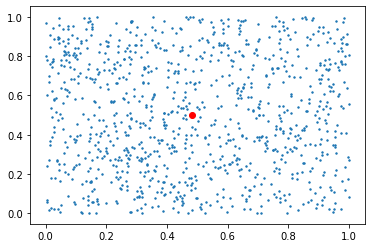

In [6]:
xcm = np.sum(m[None, :] * x, axis=1) / np.sum(m)

# Let's plot things and see if it makes sense:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[0], x[1], s=2)
plt.plot([xcm[0]],[xcm[1]], 'ro')
plt.show()

OK, the moment of inertia is not that much harder


In [7]:
# First let's compute the displacements wrt the CoM
dx = x - xcm[:, None]
inert = np.sum(m[None, None, :] * dx[:, None, :] * dx[None, :, :], axis=-1) / np.sum(m)
print(inert)

[[0.08330124 0.0008158 ]
 [0.0008158  0.0843139 ]]


Now, for posterity, let's write a function that, given a cloud of particles, will give us both the center of mass and the inertia tensor

In [8]:
def xcm_and_inertia(x_pos, mass):
    # Total mass
    mtot = np.sum(mass)
    # Center of mass
    x_cm = np.sum(x_pos * mass[None, :], axis=-1) / mtot
    # Inertia tensor
    dx = x_pos - x_cm[:, None]
    inert = np.sum(mass[None, None, :] * dx[:, None, :] * dx[None, :, :], axis=-1) / mtot
    return x_cm, inert
    

Right, let's do the **sphere**. In this case, we need to think about how we will generate the positions so that they are homogeneously distributed in the sphere. If we, for instance, generate their radial coordinate $r$ as a random variable, we will be putting a lot more particles towards the centre than towards the edge.

The trick here is to use coordinates $u_r$, $u_\varphi$ and $u_\theta$ that are homogeneously distributed. We can do so by writing the volume element as:
\begin{equation}
  dV = r^2 dr\,\sin\theta d\theta\,d\varphi = du_r\,du_\varphi\,du_\theta,
\end{equation}
This means that $u_r = r^3/3$, $u_\theta=\cos\theta$ and $u_\varphi=\varphi$.

OK, so we first generate random $(u_r,u_\theta,u_\varphi)$, then we translate them into $(r,\theta,\varphi)$ and then into $(x,y,z)$.

In [9]:
# u coordinates
ur = np.random.rand(npart)/3
utheta = -1 + 2 * np.random.rand(npart)
phi = 2 * np.pi * np.random.rand(npart)

# spherical coordinates
r = (3 * ur)**(1/3)
theta = np.arccos(utheta)

# Cartesian coordinates
x_sphere = np.array([r * np.sin(theta) * np.cos(phi),
                     r * np.sin(theta) * np.sin(phi),
                     r * np.cos(theta)])

OK, let's plot the particle positions!

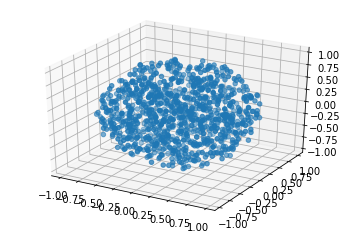

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x_sphere[0], x_sphere[1], x_sphere[2])
plt.show()

And finally, we use the function we created above to compute the center of mass and the inertia tensor:

In [11]:
xcm, inert = xcm_and_inertia(x_sphere, m)
print("x_CM = ", xcm)
print("I = \n", inert)

x_CM =  [ 0.00076408 -0.00910724 -0.01158042]
I = 
 [[ 0.20087052  0.0108858   0.00094609]
 [ 0.0108858   0.19774603 -0.00242578]
 [ 0.00094609 -0.00242578  0.19988427]]


The **ellipsoid** is just a sphere distorted in each direction. So we can just generate those coordinates by multiplying each dimension by its corresponding axis:

In [12]:
a = 1
b = 3/4
c = 4/3

x_ellip = np.array([x_sphere[0] * a,
                    x_sphere[1] * b,
                    x_sphere[2] * c])

xcm, inert = xcm_and_inertia(x_ellip, m)
print("x_CM = ", xcm)
print("I = \n", inert)

x_CM =  [ 0.00076408 -0.00683043 -0.01544056]
I = 
 [[ 0.20087052  0.00816435  0.00126145]
 [ 0.00816435  0.11123214 -0.00242578]
 [ 0.00126145 -0.00242578  0.35534981]]


## Problem 3
Let's play around with Markov chains. Markov chains are sequences of numbers $\{a_n,\,n\in[1,N]\}$ where the value of the $n$-th element depends on the values of the preceding ones. For simplicity, we'll make $a_n$ depend only on $a_{n-1}$.

1. Write a function that generates a Markov chain of length $N$ defined as follows:
\begin{equation}
a_n = a_{n-1} + r_G,
\end{equation}
where $r_G$ is a random number drawn from a Gaussian distribution with zero mean and standard deviation $\sigma=0.01$.
2. Generate 3 chains with $N=1000$ and plot them.
3. By generating many chains, compute the correlation function, defined as:
\begin{equation}
\xi(|n-m|) = \langle a_n a_m\rangle,
\end{equation}
where the angle brackets $\langle ...\rangle$ denote averaging over many chains and over all pairs $n$ and $m$ with the same "distance" $d=|n-m|$.

### Solution
OK, the first part can be done in an inefficient way (using a `for` loop), or in an efficient way. For the second one, let's first realize that:
\begin{align}
  a_n &= a_{n-1}+r_{G,n}\\
      &= a_{n-2}+r_{G,n-1}+r_{G,n-2}\\
      &= ...\\
      &= a_0 + r_{G,1} + r_{G,2}+...+r_{G,n}
\end{align}
So this is a "cumulative sum", and there are numpy functions for this!

In [13]:
def get_chain(N):
    # First, we generate N random numbers
    r = np.random.randn(N)
    # Then we compute their cumulative sum
    chain = np.cumsum(r)
    return chain

Let's plot a few chains

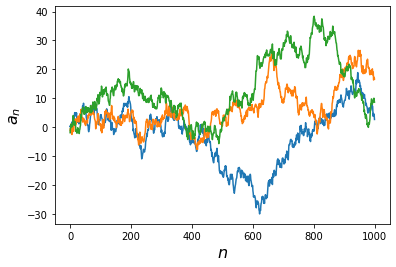

In [14]:
n_chains = 3
n_elements = 1000

plt.figure()
for i in range(n_chains):
    chain = get_chain(n_elements)
    plt.plot(chain)
plt.xlabel('$n$', fontsize=16)
plt.ylabel('$a_n$', fontsize=16)
plt.show()

Finally, to compute the correlation function efficiently, we make use of histograms.
 - First, we compute how many pairs of elements are separated by a given distance: this is just a histogram of the pair-wise distance.
 - Then, we compute the sum of the products of the chain elements for those pairs: this is a weighted histogram of the pair-wise distance, where the weight for a given pair of elements is their product.
 - Then, we divide both numbers and presto!

Let's create a function that does this for a given chain

In [15]:
def corr_func(chain):
    # Compute the number of elements
    n_el = len(chain)
    # Indices for each element in the chain
    pos = np.arange(n_el)
    # Relative positions between each pair of elements
    rel_pos = np.fabs(pos[:, None] - pos[None, :]).flatten()
    # Histogram of pairwise distances
    n_pairs, edges = np.histogram(rel_pos,
                                  bins=n_el,
                                  range=[0, n_el])
    # Weighted histogram
    product_sum, _ = np.histogram(rel_pos,
                                  bins=n_el,
                                  range=[0, n_el],
                                  weights=np.outer(chain, chain).flatten())
    # Divide!
    # (Question: why should I not worry about dividing by zero?)
    corr = product_sum / n_pairs
    return corr

Now let's loop over 100 chains and compute the average

In [16]:
n_chains = 100
xi = np.zeros(n_elements)
for i in range(n_chains):
    if i%10==0:
        print(f'{i}-th chain')
    xi += corr_func(get_chain(n_elements))
xi /= n_chains
# Question: can you think of a one-line statement that does all of the above?

0-th chain
10-th chain
20-th chain
30-th chain
40-th chain
50-th chain
60-th chain
70-th chain
80-th chain
90-th chain


Let's plot!

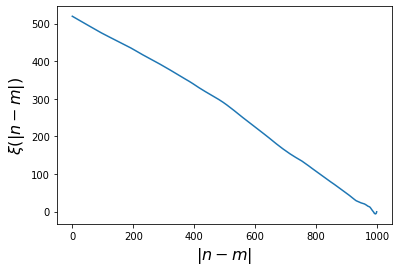

In [17]:
plt.figure()
plt.plot(xi)
plt.xlabel(r'$|n-m|$', fontsize=16)
plt.ylabel(r'$\xi(|n-m|)$', fontsize=16)
plt.show()